In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from ipywidgets import interact
from IPython.display import clear_output

In [3]:
def adder(d1, d2, c):
    s = d1 + d2 + c
    # returns print, carry
    return [[0, 0], [1, 0], [0, 1], [1, 1]][s]

def data(s=6):
    a = np.random.randint(2, size=s)
    b = np.random.randint(2, size=s)
    
    p = np.zeros(s, dtype=np.int32)
    c = 0
    for i in reversed(range(s)):
        d1 = a[i]
        d2 = b[i]
        pr, c = adder(a[i], b[i], c)
        p[i] = pr
    
    return a, b, p
    
a, b, p = data()

print(a)
print(b)
print(p)

[0 0 1 0 0 0]
[1 0 1 0 0 0]
[1 1 0 0 0 0]


In [161]:
# define network

TIME_STEPS = 4

IN = 2
H = 5
OUT = 1

def weight_variable(size):
    initial = tf.random_normal(size)
    return tf.Variable(initial)

def bias_variable(size):
    initial = tf.constant(.1, shape=size)
    return tf.Variable(initial)

# Initial state of h
h_p = tf.placeholder(tf.float32, shape=[1, H])

# Input placeholders for 3 pairs of digits
xs = [tf.placeholder(tf.float32, shape=[1, IN]) for i in range(TIME_STEPS)]
    
#x1 = tf.placeholder(tf.float32, shape=[1, IN])
#x2 = tf.placeholder(tf.float32, shape=[1, IN])
#x3 = tf.placeholder(tf.float32, shape=[1, IN])

# Targets for the 3 outputs
ts = [tf.placeholder(tf.float32, shape=[1, OUT]) for i in range(TIME_STEPS)]
#t1 = tf.placeholder(tf.float32, shape=[1, OUT])
#t2 = tf.placeholder(tf.float32, shape=[1, OUT])
#t3 = tf.placeholder(tf.float32, shape=[1, OUT])

# Three weight matrices
Win = weight_variable([IN, H])
Wstate = weight_variable([H, H])
Wout = weight_variable([H, OUT])

bias_state = bias_variable([1, H])
bias_out = bias_variable([1, OUT])

# Three hidden activations, t=1,2,3
hs = []
prev_h = h_p
for i in range(TIME_STEPS):
    h = tf.tanh( tf.matmul(xs[i], Win) + tf.matmul(prev_h, Wstate) + bias_state)
    hs.append(h)
    prev_h = h
    
#h1 = tf.tanh( tf.matmul(x1, Win) + tf.matmul(h_p, Wstate) + bias_state)
#h2 = tf.tanh( tf.matmul(x2, Win) + tf.matmul(h1,  Wstate) + bias_state)
#h3 = tf.tanh( tf.matmul(x3, Win) + tf.matmul(h2,  Wstate) + bias_state)

# Three model outputs for each timestep
ys = [tf.sigmoid( tf.matmul(hs[i], Wout) + bias_out ) for i in range(TIME_STEPS)]

#y1 = tf.sigmoid( tf.matmul(h1, Wout) + bias_out )
#y2 = tf.sigmoid( tf.matmul(h2, Wout) + bias_out )
#y3 = tf.sigmoid( tf.matmul(h3, Wout) + bias_out )

cost = tf.reduce_sum( tf.add_n([tf.square(ys[i] - ts[i]) for i in range(TIME_STEPS)]) )

In [162]:
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

In [163]:
if 'session' in globals():
    session.close()
    
session = tf.InteractiveSession()
session.run(tf.initialize_all_variables())

In [444]:
def pair(i, a, b):
    return np.array([[a[i], b[i]]])

initial_h = np.zeros([1, H])

for i in range(100000):
    a, b, p = data(TIME_STEPS)
    
    #fd = {x1: pair(2, a, b), x2: pair(1, a, b), x3: pair(0, a, b), 
          #t1: [[p[2]]],      t2: [[p[1]]],      t3: [[p[0]]],
          #h_p: initial_h}
            
    fd = {h_p: initial_h}
    
    for j in range(TIME_STEPS):
        jr = TIME_STEPS - j - 1
        fd[xs[j]] = pair(jr, a, b)
        fd[ts[j]] = [[p[jr]]]
            
    session.run(train, fd)
    
    if i % 10000 == 0:
        test_batch(10)

correct: 70.0%
correct: 90.0%
correct: 90.0%
correct: 70.0%
correct: 80.0%
correct: 70.0%
correct: 70.0%
correct: 80.0%
correct: 60.0%
correct: 70.0%


In [ ]:
# test
def test_add():
    a, b, p = data(TIME_STEPS)
    
    #fd = {x1: pair(2, a, b), x2: pair(1, a, b), x3: pair(0, a, b), 
                        #t1: [[p[2]]],         t2: [[p[1]]],         t3: [[p[0]]],
                        #h_p: np.zeros([1, H])}
    
    fd = {h_p: initial_h}
    
    for j in range(TIME_STEPS):
        jr = TIME_STEPS - j - 1
        fd[xs[j]] = pair(jr, a, b)
        fd[ts[j]] = [[p[jr]]]
    
    #d1 = y1.eval(fd)[0, 0]
    #d2 = y2.eval(fd)[0, 0]
    #d3 = y3.eval(fd)[0, 0]
    
    digits = [ys[i].eval(fd)[0, 0] for i in range(TIME_STEPS)]
    digits.reverse()
    
    r = np.round(digits)
    r = r.astype(np.int32)
    
    print(a)
    print(b)
    
    print(' ')
    
    print('model: {}'.format(r))
    print('true:  {}'.format(p))
    
test_add()

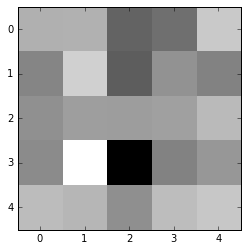

In [238]:
#Wstate.eval()

plt.imshow(Wstate.eval(), cmap=plt.cm.gray, interpolation='nearest')

In [358]:
# add up longer numbers by transitioning state

def test_add_long(s):
    a, b, p = data(s)
    model = np.zeros([s])
    
    h_state = np.zeros([1, 5])
    for i in reversed(range(len(a))):
        fd = {xs[0]: pair(i, a, b),
              h_p: h_state}
        h_state = hs[0].eval(fd)
        model_p = ys[0].eval(fd)
        model[i] = model_p
    
    model = np.round(model)
    model = model.astype(np.int32)
    
    wrong = np.sum(np.logical_xor(model, p))
    percentage = (s-wrong) / float(s)
    
    return model, p, wrong
        
model, true, wrong = test_add_long(10)

print(true)
print(model)
print('wrong: {}'.format(wrong))

[1 0 1 0 1 1 0 1 0 0]
[1 0 1 0 0 1 0 1 0 0]
wrong: 1


In [441]:
def test_batch(b):
    s = 10 # add up 10 digit numbers
    w = 0.0
    for i in range(b):
        model, true, wrong = test_add_long(s)
        if wrong > 0:
            w += 1.0
    print('correct: {}%'.format(100.0 * float((b - w)) / float(b)))
    
test_batch(25)

correct: 80.0%
